In [4]:
# 파일 경로 지정
import sys, os
from IPython import get_ipython
notebook_dir = os.path.dirname(os.path.abspath(get_ipython().run_line_magic('pwd', '')))
sys.path.append(notebook_dir)

In [5]:
# 데이터 로드
import pandas as pd
from lib import data_preprocessor

# 데이터 csv를 dataFrame으로 변환
df = data_preprocessor.transform_verilog_results_to_DataFrame('../data/data_unif.csv')
normal_df, data_min, data_max = data_preprocessor.normalize_DataFrame(df)

[] columns are dropped.


In [6]:
# 모델 로드
import torch, joblib
from torch.utils.data import DataLoader
from lib import ANN
from lib import CNN_new
from lib import LSTM

input_feature = ['i' + str(i) for i in range(0, 63)]
output_feature = ['phig', 'cit', 'u0', 'ua', 'eu', 'etamob', 'up', 'rdsw']

ann_model = ANN.ANN(len(input_feature), len(output_feature))
ann_model.load_state_dict(torch.load('../Model/ann_model_weights.pth'))
ann_model.eval()

rf_model = joblib.load('../Model/random_forest_model.pkl')

cnn_model = CNN_new.CNN(len(input_feature), len(output_feature))
cnn_model.load_state_dict(torch.load('../Model/cnn_model_weights.pth'))
cnn_model.eval()

gbm_model = joblib.load('../Model/gbm_model.pkl')

lstm_model = LSTM.LSTM(len(input_feature), len(output_feature))
lstm_model.load_state_dict(torch.load('../Model/lstm_model_weights.pth'))
lstm_model.eval()

C:\Users\LG\AppData\Local\Temp\ipykernel_1376\3525589770.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ann_model.load_state_dict(torch.load('../Model/ann_model_weight

LSTM(
  (lstm): LSTM(63, 128, num_layers=3, batch_first=True)
  (fc): Linear(in_features=128, out_features=8, bias=True)
)

In [2]:
# 모델 input 데이터 생성
import numpy as np
import pickle, json
from lib import SSHManager, app

# 데이터 중 랜덤하게 n개를 뽑아 테스트 데이터로 사용한다.
n = 100
test_df = normal_df.sample(n)

# 모델들을 dict로 저장한다.
model_names = ['ann', 'rf', 'cnn', 'gbm', 'lstm']
models = [ann_model, rf_model, cnn_model, gbm_model, lstm_model]

name_pytorch = ['ann', 'cnn', 'lstm']
name_sklearn = ['rf', 'gbm']

# 각 모델들의 결과를 저장할 dict를 생성한다.
# 결과를 list로 저장되고, 각 list는 model_names를 key로 한다.
result_parameters: dict = {name: [] for name in model_names}
result_i: dict = {name: [] for name in model_names}

# 서버에 연결한다.
server_info = json.load(open("../server_info.json", "r"))
ssh = SSHManager.SSHManager(server_info["host"], server_info["port"], server_info["id"], server_info["password"])

number_of_parameter = len(output_feature)
i_max = data_max[input_feature].to_numpy()
i_min = data_min[input_feature].to_numpy()

for model, name in zip(models, model_names):

    print(f"\n\nModel: {name}\n\n")

    # i_ons, i_offs, HSPICE_i를 초기화한다.
    parameters = []
    HSPICE_i: list = []
    index = 0

    for _, data in test_df.iterrows():

        # input_feature에 대한 데이터를 추출한다.
        normal_i = data[input_feature].to_numpy()
        unnormal_i = normal_i * (data_max[input_feature] - data_min[input_feature]) + data_min[input_feature]


        # model이 사용된 라이브러리에 따라 다른 input을 사용한다.
        if name in name_pytorch:
            pred_pytorch = model(torch.tensor(normal_i, dtype=torch.float32).unsqueeze(0))
            pred_pytorch_numpy = pred_pytorch.detach().numpy().squeeze()

            # 결과를 역정규화한다.
            unnormal_pred = pred_pytorch_numpy * (data_max[output_feature] - data_min[output_feature]) + data_min[output_feature]

        # 만약, model이 sklearn 모델이라면,
        elif name in name_sklearn:
            df = pd.DataFrame([normal_i], columns=input_feature)
            pred_sklearn = model.predict(df)

            # 결과를 역정규화한다.
            # rf는 8개의 데이터를 가진 numpy array를 묶어서 반환하기 때문에 [0]을 붙여준다.
            unnormal_pred = pred_sklearn[0] * (data_max[output_feature] - data_min[output_feature]) + data_min[output_feature]
            

        # 모두 해당되지 않는다면, 에러를 출력한다.
        else:
            raise ValueError("Model name error")

        # unnormal_pred를 저장한다.
        parameters.append(unnormal_pred)

        # get_value_with_parameter 함수를 통해 HSPICE를 실행하고 결과 파일을 받는다.
        # 받은 파일 결과는 result에 list 형태로 한 줄씩 저장된다.
        app.get_value_with_parameter(unnormal_pred, ssh, "/home/mario/User/cws/test/")
        with open("result.txt", "r") as f:
            result = f.readlines()

        # HSPICE 실행 결과에서 i값을 추출한다.
        result = result[1200:]
        i = app.remove_unit(result)
        HSPICE_i.append(i)

        # result.txt 파일을 지운다.
        os.remove("result.txt")

        # 만약 index가 0이라면, i_on, i_off, parameter를 출력한다.
        if index == 0:
            print(f'model: {model}')
            print(f'parameters: {unnormal_pred}')
            print(f"i: {i}")
        if index % 10 == 0:
            print(f'{name}의 {index}번째 실행 중...')
        index += 1

    print(f'{name}이 종료됨. 실행 길이: {len(i), len(parameters)}')

    # i_on, i_off에 대한 for문이 종료되면 결과를 저장한다.
    result_parameters[name].append(parameters)
    result_i[name].append(HSPICE_i)

# 서버와의 연결을 종료한다.
ssh.close()

ImportError: cannot import name 'SSHManager' from 'lib' (unknown location)

In [8]:
# 결과를 csv로 저장한다.
# 각 모델 별로 dataFrame을 만들고 합쳐 csv로 저장한다.
results_df = {name: pd.DataFrame() for name in model_names}
for name in model_names:

    print(f"\n\n{name} 결과 저장 중...\n\n")

    # 변수 초기화
    parameters = {}
    i = {}

    # 아래 두 줄로 불러왔을 때, parameters[name]의 shape는 (100, 8), i[name]의 shape는 (100, 63)이다.
    parameters[name] = np.array(result_parameters[name]).squeeze()
    i[name] = np.array(result_i[name]).squeeze()

    parameter_columns = [column + '_' + name for column in output_feature]
    result_df = pd.DataFrame(parameters[name], columns=parameter_columns)

    # input_feature로 column을 만든다.
    i_columns = [column + '_' + name for column in input_feature]
    i_df = pd.DataFrame(i[name], columns=i_columns)

    # i_df와 result_df를 합친다.
    results_df[name] = pd.concat([i_df, result_df], axis=1)
    print(results_df[name].shape)

    # i, parameter의 첫번째 값을 출력한다.
    print(f"i_{name}: {i[name][0]}")
    print(f"parameter_{name}: {result_df.iloc[0]}")

# i_original_df를 index가 제거된 상태로 저장한다.
i_original_df = test_df[input_feature] * (data_max[input_feature] - data_min[input_feature]) + data_min[input_feature]
i_original_df = i_original_df.reset_index(drop=True)

# result_df를 합친다.
result_list = [i_original_df] + [results_df[name] for name in model_names]
result_df = pd.concat(result_list, axis=1)
result_df.to_csv('result.csv', index=False)

NameError: name 'model_names' is not defined

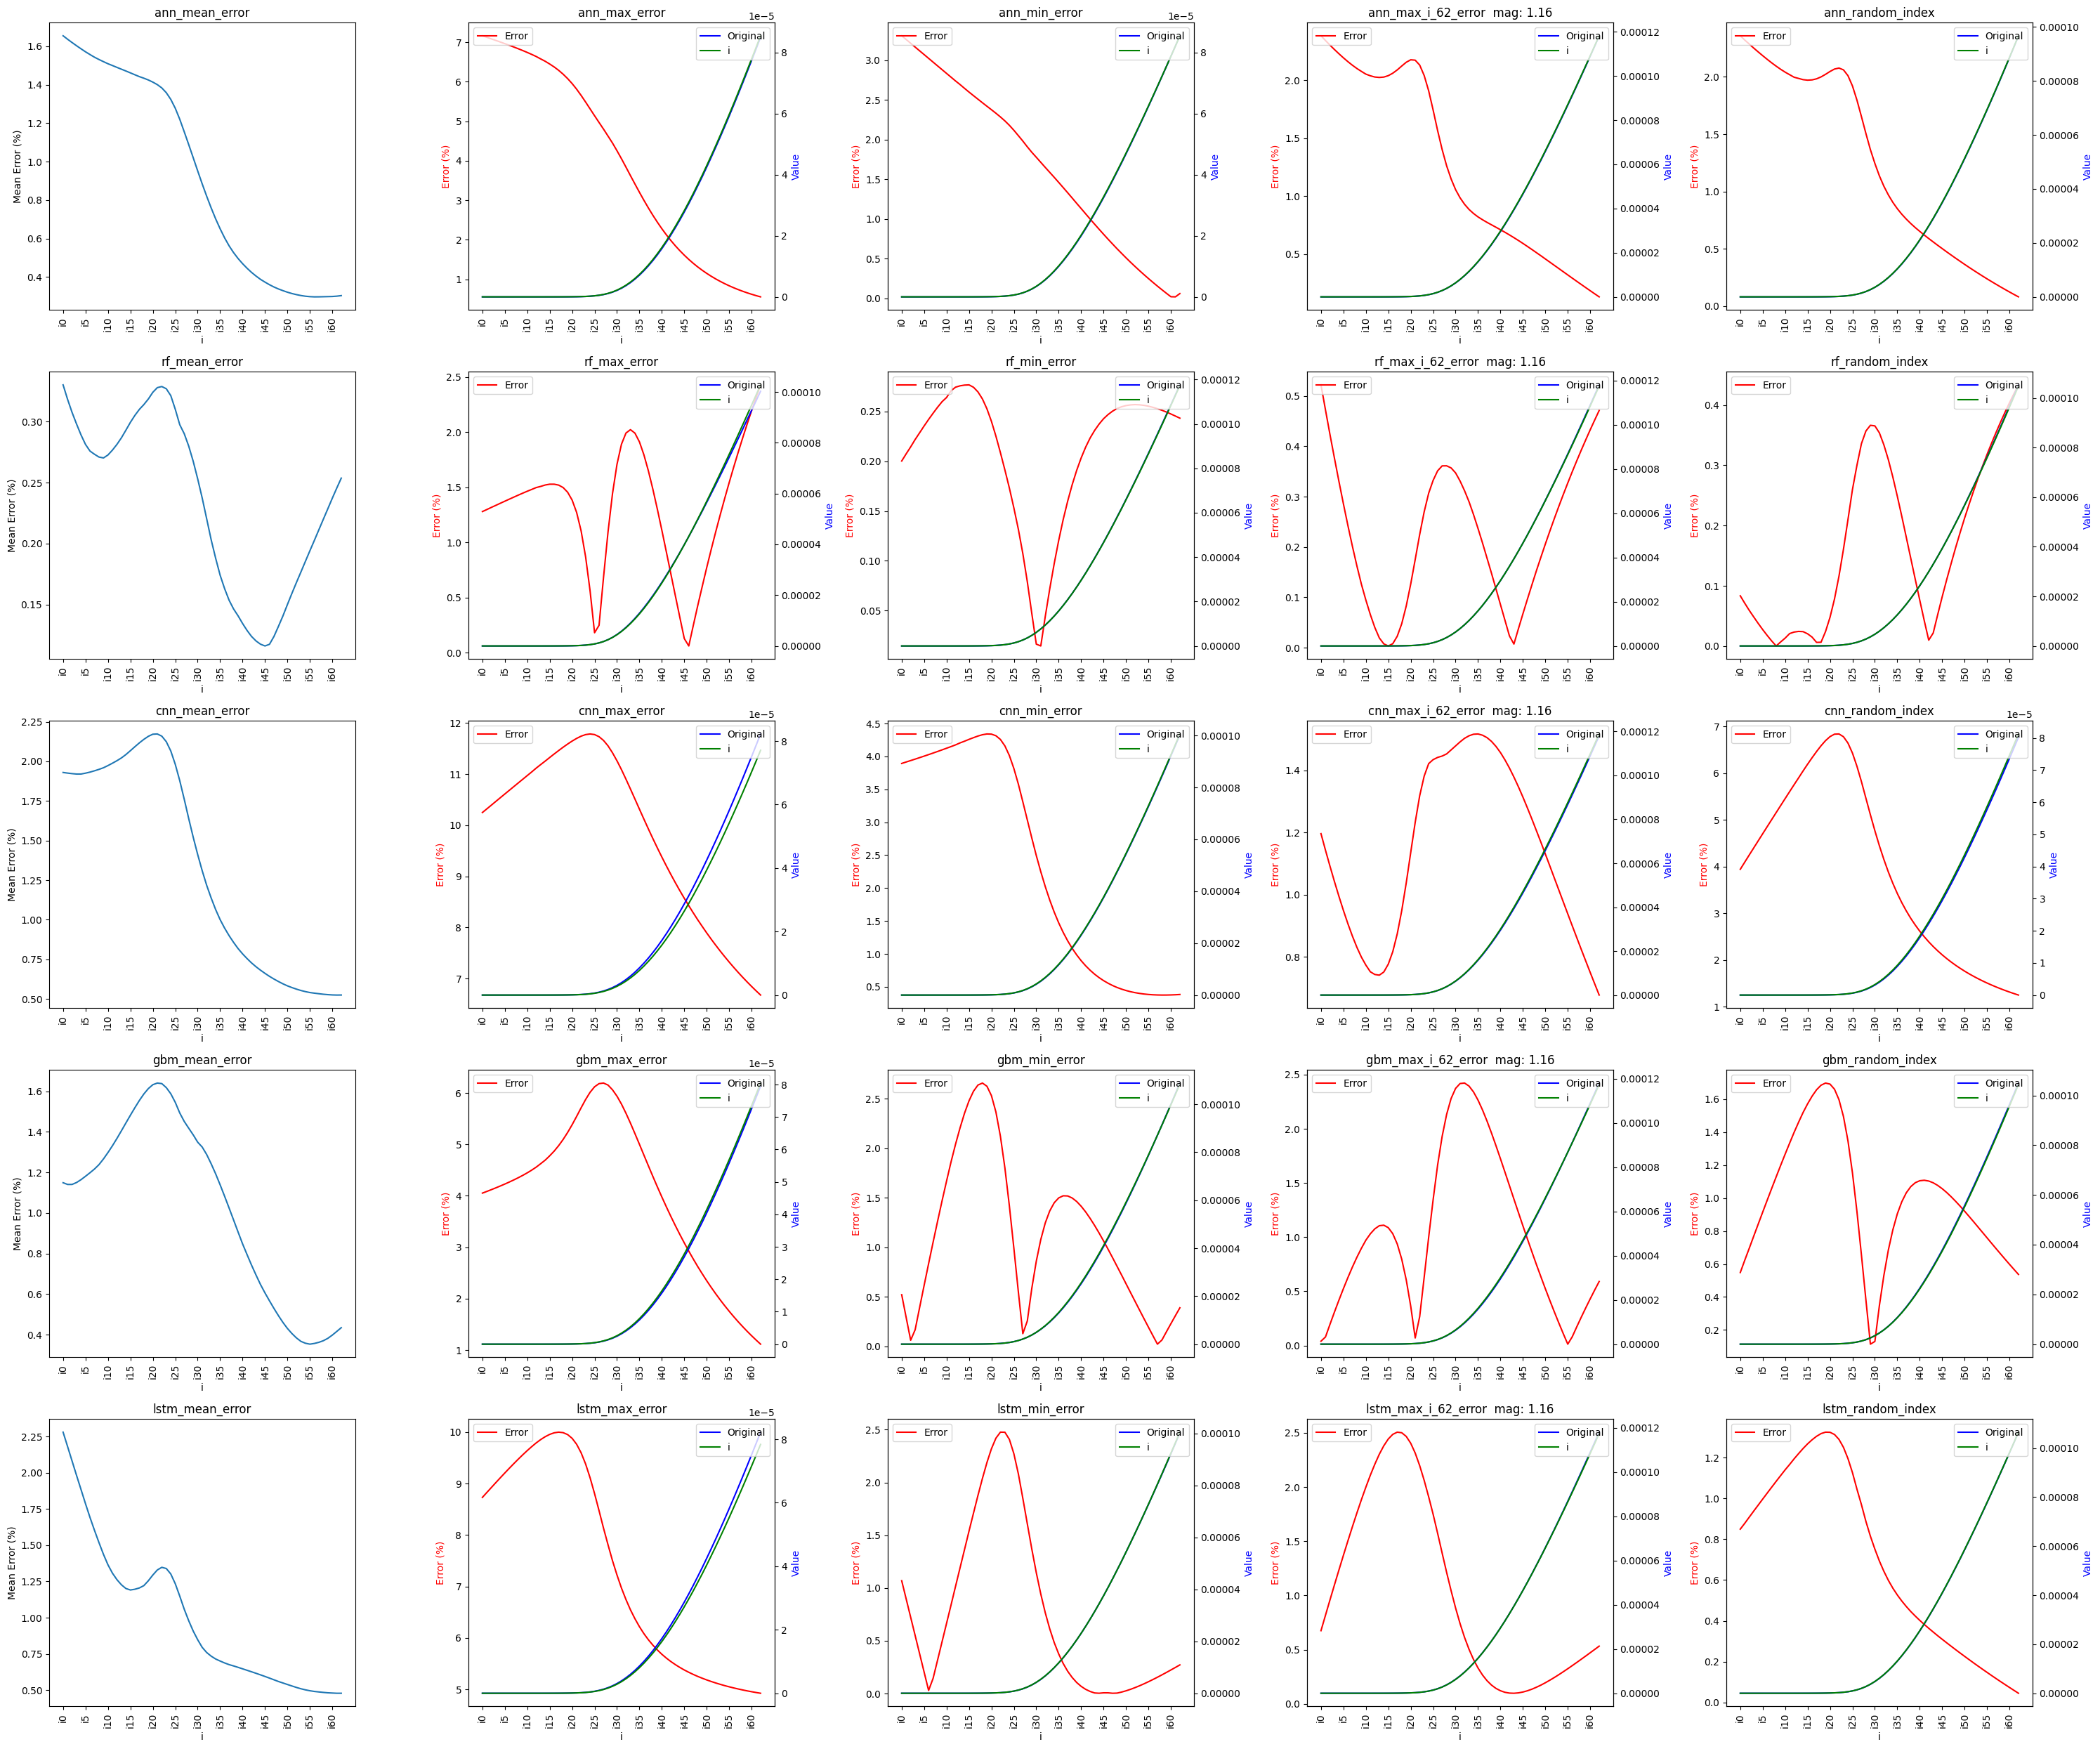

In [15]:
# 결과를 matplotlib으로 출력

import matplotlib.pyplot as plt
import pandas as pd, numpy as np

# 데이터의 i_62 중간값을 구한다.
i_62 = normal_df['i62'][0] * (data_max['i62'] - data_min['i62']) + data_min['i62']

result_df = pd.read_csv('result.csv')
model_names = ['ann', 'rf', 'cnn', 'gbm', 'lstm']

# 출력하고자 하는 대상은, i0~i62 각각에 대한 error, 가장 큰 error를 가지는 전류, 가장 작은 error를 가지는 전류이다.
fig: plt.Figure = None
ax: plt.Axes = None
fig, ax = plt.subplots(len(model_names), 5, figsize=(30, 5 * len(model_names)))

for name, index in zip(model_names, range(len(model_names))):
    params = result_df[[column + '_' + name for column in output_feature]].to_numpy()
    i_original = result_df[input_feature].to_numpy()
    i = result_df[[column + '_' + name for column in input_feature]].to_numpy()

    # i0~i62 각각에 대한 error 목록 (퍼센트)
    i_error = np.abs((i_original - i) / i) * 100

    # 그 평균에 해당하는 값 (퍼센트)
    mean_error = i_error.mean(axis=0)

    # 가장 큰 i_error를 가지는 index를 찾아, 그래프 위에 해당 index의 i와 original_i를 모두 표시한다.
    max_i_error = i_error.max(axis=1)
    max_i_error_index = max_i_error.argmax()

    # 가장 작은 mean_error를 가지는 index를 찾아, 그래프 위에 해당 index의 i와 original_i를 모두 표시한다.
    min_mean_error_index = mean_error.argmin()

    # i_62가 가장 큰 error를 가지는 index를 찾아, 그래프 위에 해당 index의 i와 original_i를 모두 표시한다.
    max_i_62_error_index = i_original[:, -1].argmax()
    
    # 무작위로 선택된 하나의 index에 대해, 그래프 위에 해당 index의 i와 original_i를 모두 표시한다.
    random_index = np.random.randint(0, i_error.shape[0])

    # 변수 설정
    tick_spacing = 5

    # 그래프를 그린다.
    x = range(63)

    # mean_error 그래프
    ax[index, 0].plot(x, mean_error, label='Mean Error (%)')
    ax[index, 0].set_xticks(range(0, 63, tick_spacing))
    ax[index, 0].set_xticklabels(input_feature[::5], rotation=90)
    ax[index, 0].set_xlabel('i')
    ax[index, 0].set_ylabel('Mean Error (%)')
    ax[index, 0].set_title(name + '_mean_error')

    # max_i_error 그래프
    ax1 = ax[index, 1]
    ax2 = ax1.twinx()
    ax1.plot(x, i_error[max_i_error_index], 'r-', label='Error')
    ax2.plot(x, i_original[max_i_error_index], 'b-', label='Original')
    ax2.plot(x, i[max_i_error_index], 'g-', label='i')
    ax1.set_xticks(range(0, 63, tick_spacing))
    ax1.set_xticklabels(input_feature[::5], rotation=90)
    ax1.set_xlabel('i')
    ax1.set_ylabel('Error (%)', color='r')
    ax2.set_ylabel('Value', color='b')
    ax1.set_title(name + '_max_error')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # min_mean_error 그래프
    ax1 = ax[index, 2]
    ax2 = ax1.twinx()
    ax1.plot(x, i_error[min_mean_error_index], 'r-', label='Error')
    ax2.plot(x, i_original[min_mean_error_index], 'b-', label='Original')
    ax2.plot(x, i[min_mean_error_index], 'g-', label='i')
    ax1.set_xticks(range(0, 63, tick_spacing))
    ax1.set_xticklabels(input_feature[::5], rotation=90)
    ax1.set_xlabel('i')
    ax1.set_ylabel('Error (%)', color='r')
    ax2.set_ylabel('Value', color='b')
    ax1.set_title(name + '_min_error')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # max_i_62_error 그래프
    ax1 = ax[index, 3]
    ax2 = ax1.twinx()
    ax1.plot(x, i_error[max_i_62_error_index], 'r-', label='Error')
    ax2.plot(x, i_original[max_i_62_error_index], 'b-', label='Original')
    ax2.plot(x, i[max_i_62_error_index], 'g-', label='i')
    ax1.set_xticks(range(0, 63, tick_spacing))
    ax1.set_xticklabels(input_feature[::5], rotation=90)
    ax1.set_xlabel('i')
    ax1.set_ylabel('Error (%)', color='r')
    ax2.set_ylabel('Value', color='b')
    ax1.set_title(name + '_max_i_62_error' + '  mag: ' + str(round(i_original[max_i_62_error_index][-1]/i_62, 2)))
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    # random_index 그래프
    ax1 = ax[index, 4]
    ax2 = ax1.twinx()
    ax1.plot(x, i_error[random_index], 'r-', label='Error')
    ax2.plot(x, i_original[random_index], 'b-', label='Original')
    ax2.plot(x, i[random_index], 'g-', label='i')
    ax1.set_xticks(range(0, 63, tick_spacing))
    ax1.set_xticklabels(input_feature[::5], rotation=90)
    ax1.set_xlabel('i')
    ax1.set_ylabel('Error (%)', color='r')
    ax2.set_ylabel('Value', color='b')
    ax1.set_title(name + '_random_index')
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('error.png')